# ABC calibration of $I_\text{Na}$ in Nygren model using original dataset.

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

INFO:myokit:Loading Myokit version 1.29.1


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used by Nygren $I_\text{Na}$ model in the publication:
 - Steady-state activation [Sakakibara1992]
 - Steady-state inactivation [Sakakibara1992]

In [4]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact)

Load the myokit modelfile for this channel.

In [5]:
modelfile = 'models/nygren_ina.mmt'

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [7]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act,
                                                sakakibara_inact)
assert len(observations)==len(summary_statistics(model({}))) # check output correct

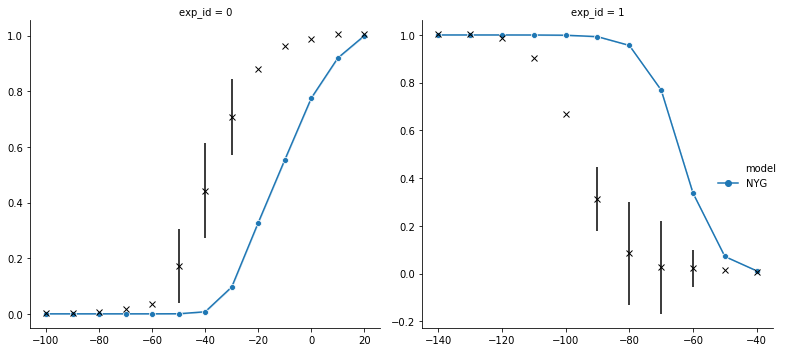

In [7]:
# Test the output of the unaltered model.
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     sakakibara_inact)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [8]:
limits = {'ina.s1': (0, 1),
          'ina.r1': (0, 100),
          'ina.r2': (0, 20),
          'ina.q1': (0, 200),
          'ina.q2': (0, 20),
          'log_ina.r3': (-6, -3),
          'ina.r4': (0, 100),
          'ina.r5': (0, 20),
          'log_ina.r6': (-6, -3),
          'log_ina.q3': (-3., 0.),
          'ina.q4': (0, 200),
          'ina.q5': (0, 20),
          'log_ina.q6': (-5, -2),
          'log_ina.q7': (-3., 0.),
          'log_ina.q8': (-4, -1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [9]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

## Run ABC-SMC inference

Set-up path to results database.

In [10]:
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_ina_original.db")

In [11]:
# Add logging for additional information during run.
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

Test theoretical number of particles for approximately 2 particles per dimension in the initial sampling of the parameter hyperspace.

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32768 particles


Initialise ABCSMC (see pyABC documentation for further details).

IonChannelDistance calculates the weighting applied to each datapoint based on the experimental variance.

In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(10000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.1375036597030084, '1': 1.1375036597030084, '2': 1.1375036597030084, '3': 1.1375036597030084, '4': 1.1375036597030084, '5': 0.4313764851842987, '6': 0.33560921419107864, '7': 0.41713842292079123, '8': 1.1375036597030084, '9': 1.1375036597030084, '10': 1.1375036597030084, '11': 1.1375036597030084, '12': 1.1375036597030084, '13': 1.3443225069217373, '14': 1.3443225069217373, '15': 1.3443225069217373, '16': 1.3443225069217373, '17': 1.3443225069217373, '18': 0.5042489333570933, '19': 0.3133612496186395, '20': 0.3470799976569435, '21': 0.8658915515889136, '22': 1.3443225069217373, '23': 1.3443225069217373}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [14]:
# Convert observations to dictionary format for calibration
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
# Initialise run and set ID for this run.
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2020-01-17 10:45:32.161771, end_time=None)>


Run calibration with stopping criterion of particle 1\% acceptance rate.

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 0, eps: 20.
DEBUG:ABC:Now submitting population 0.
DEBUG:ABC:Population 0 done.


## Analysis of results

In [17]:
history = History(db_path)

In [18]:
df, w = history.get_distribution(m=0)

In [19]:
df.describe()

name,ina.q1,ina.q2,ina.q4,ina.q5,ina.r1,ina.r2,ina.r4,ina.r5,ina.s1,log_ina.q3,log_ina.q6,log_ina.q7,log_ina.q8,log_ina.r3,log_ina.r6
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,95.525423,6.550577,65.759581,12.337859,52.230783,10.849712,57.912997,8.845355,0.510411,-1.373953,-3.377468,-1.368960,-2.536748,-4.742989,-4.405623
std,0.256586,0.209663,59.123520,4.716001,0.635671,0.584810,22.865675,5.268834,0.276427,0.781718,0.786296,0.781742,0.806633,0.712481,0.846754
min,94.769933,5.728864,0.002995,0.037145,48.240216,8.853093,0.039577,0.000761,0.000843,-2.999259,-4.999408,-2.999570,-3.999497,-5.999612,-5.999577
25%,95.343364,6.421572,21.641514,9.286291,51.816793,10.429094,40.381427,4.425656,0.280004,-2.010097,-3.993700,-2.018116,-3.231715,-5.297853,-5.110166
50%,95.495389,6.566367,39.792882,12.863987,52.232609,10.767138,58.402636,8.387855,0.501228,-1.350758,-3.330496,-1.250095,-2.518769,-4.803675,-4.427508
75%,95.676215,6.697650,110.105986,16.041317,52.648448,11.206374,76.202997,13.038828,0.744341,-0.627784,-2.724643,-0.654821,-1.879700,-4.256667,-3.630294
max,96.794065,7.133239,199.999250,19.999072,55.070302,13.115753,99.995578,19.994372,0.999999,-0.000102,-2.000157,-0.001192,-1.000550,-3.000166,-3.000007


### Plot summary statistics compared to calibrated model output.

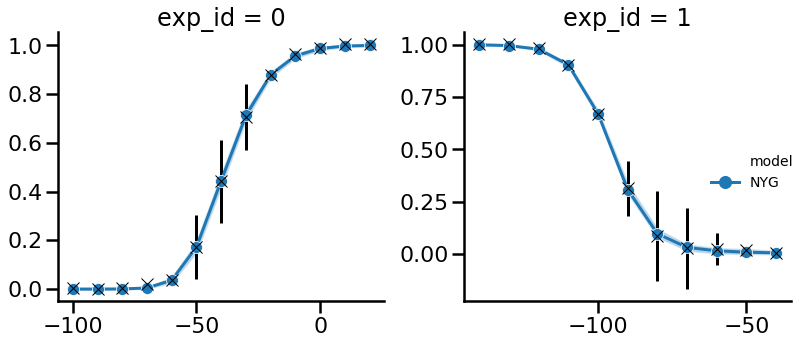

In [20]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     sakakibara_act,
                     sakakibara_inact,
                     df=df, w=w)

#xlabels = ["voltage (mV)"]*2
#ylabels = ["steady-state activation", "steady-state inactivation"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)
#for ax in g.axes.flatten():
#    ax.set_title('')

plt.tight_layout()

In [21]:
#g.savefig('figures/ina/nyg_original_sum_stats.pdf')

### Plot parameter distributions

In [22]:
m,_,_ = myokit.load(modelfile)

In [23]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

In [24]:
act_params = ['ina.r1','ina.r2','log_ina.r3','ina.r4','ina.r5','log_ina.r6']

In [25]:
df_act = df[act_params]
limits_act = dict([(key, limits[key]) for key in act_params])
originals_act = dict([(key, originals[key]) for key in act_params])

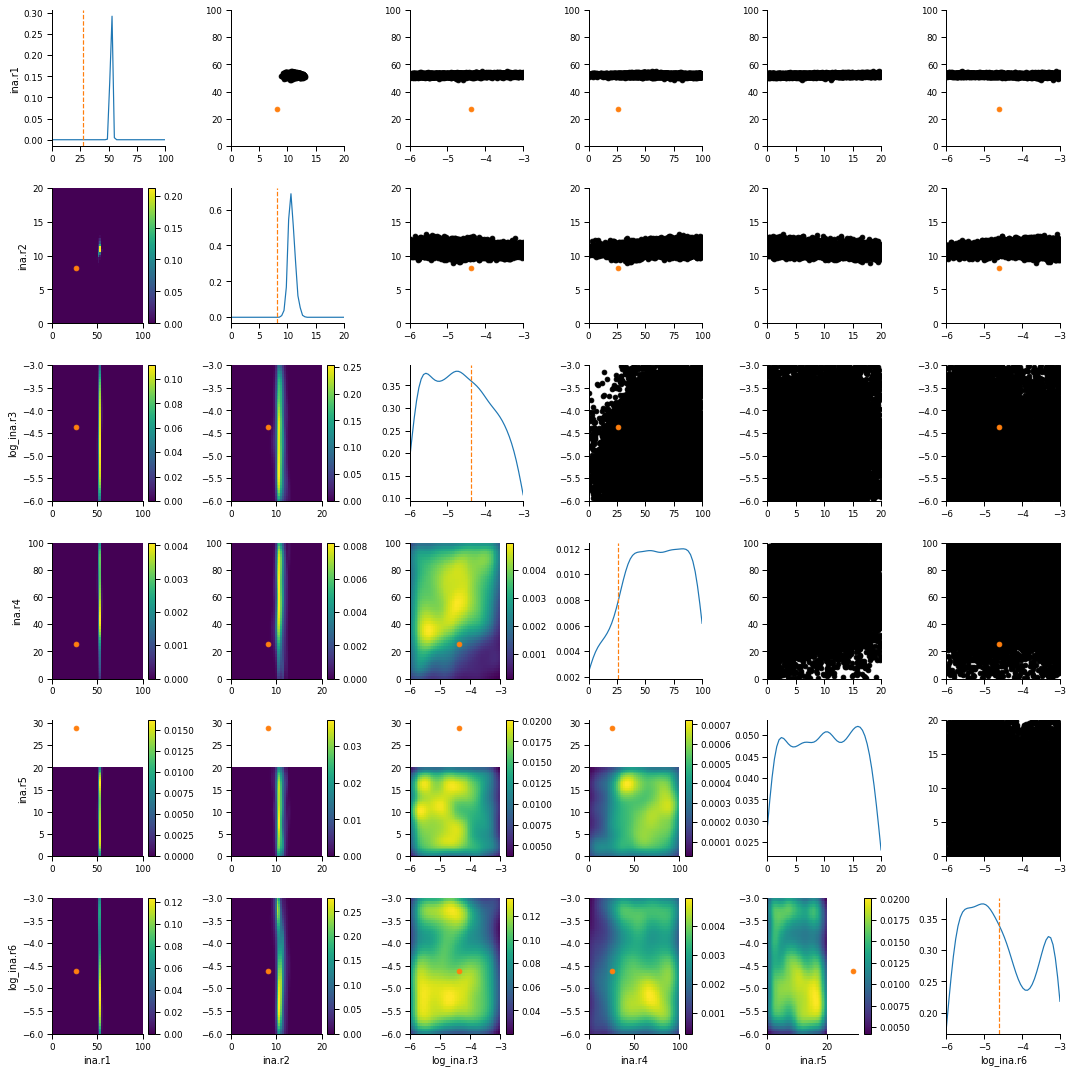

In [26]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df_act, w, limits=limits_act, refval=originals_act)

In [27]:
inact_params = ['ina.q1','ina.q2','log_ina.q3','ina.q4','ina.q5','log_ina.q6','log_ina.q7','log_ina.q8','ina.s1']

In [28]:
df_inact = df[inact_params]
limits_inact = dict([(key, limits[key]) for key in inact_params])
originals_inact = dict([(key, originals[key]) for key in inact_params])

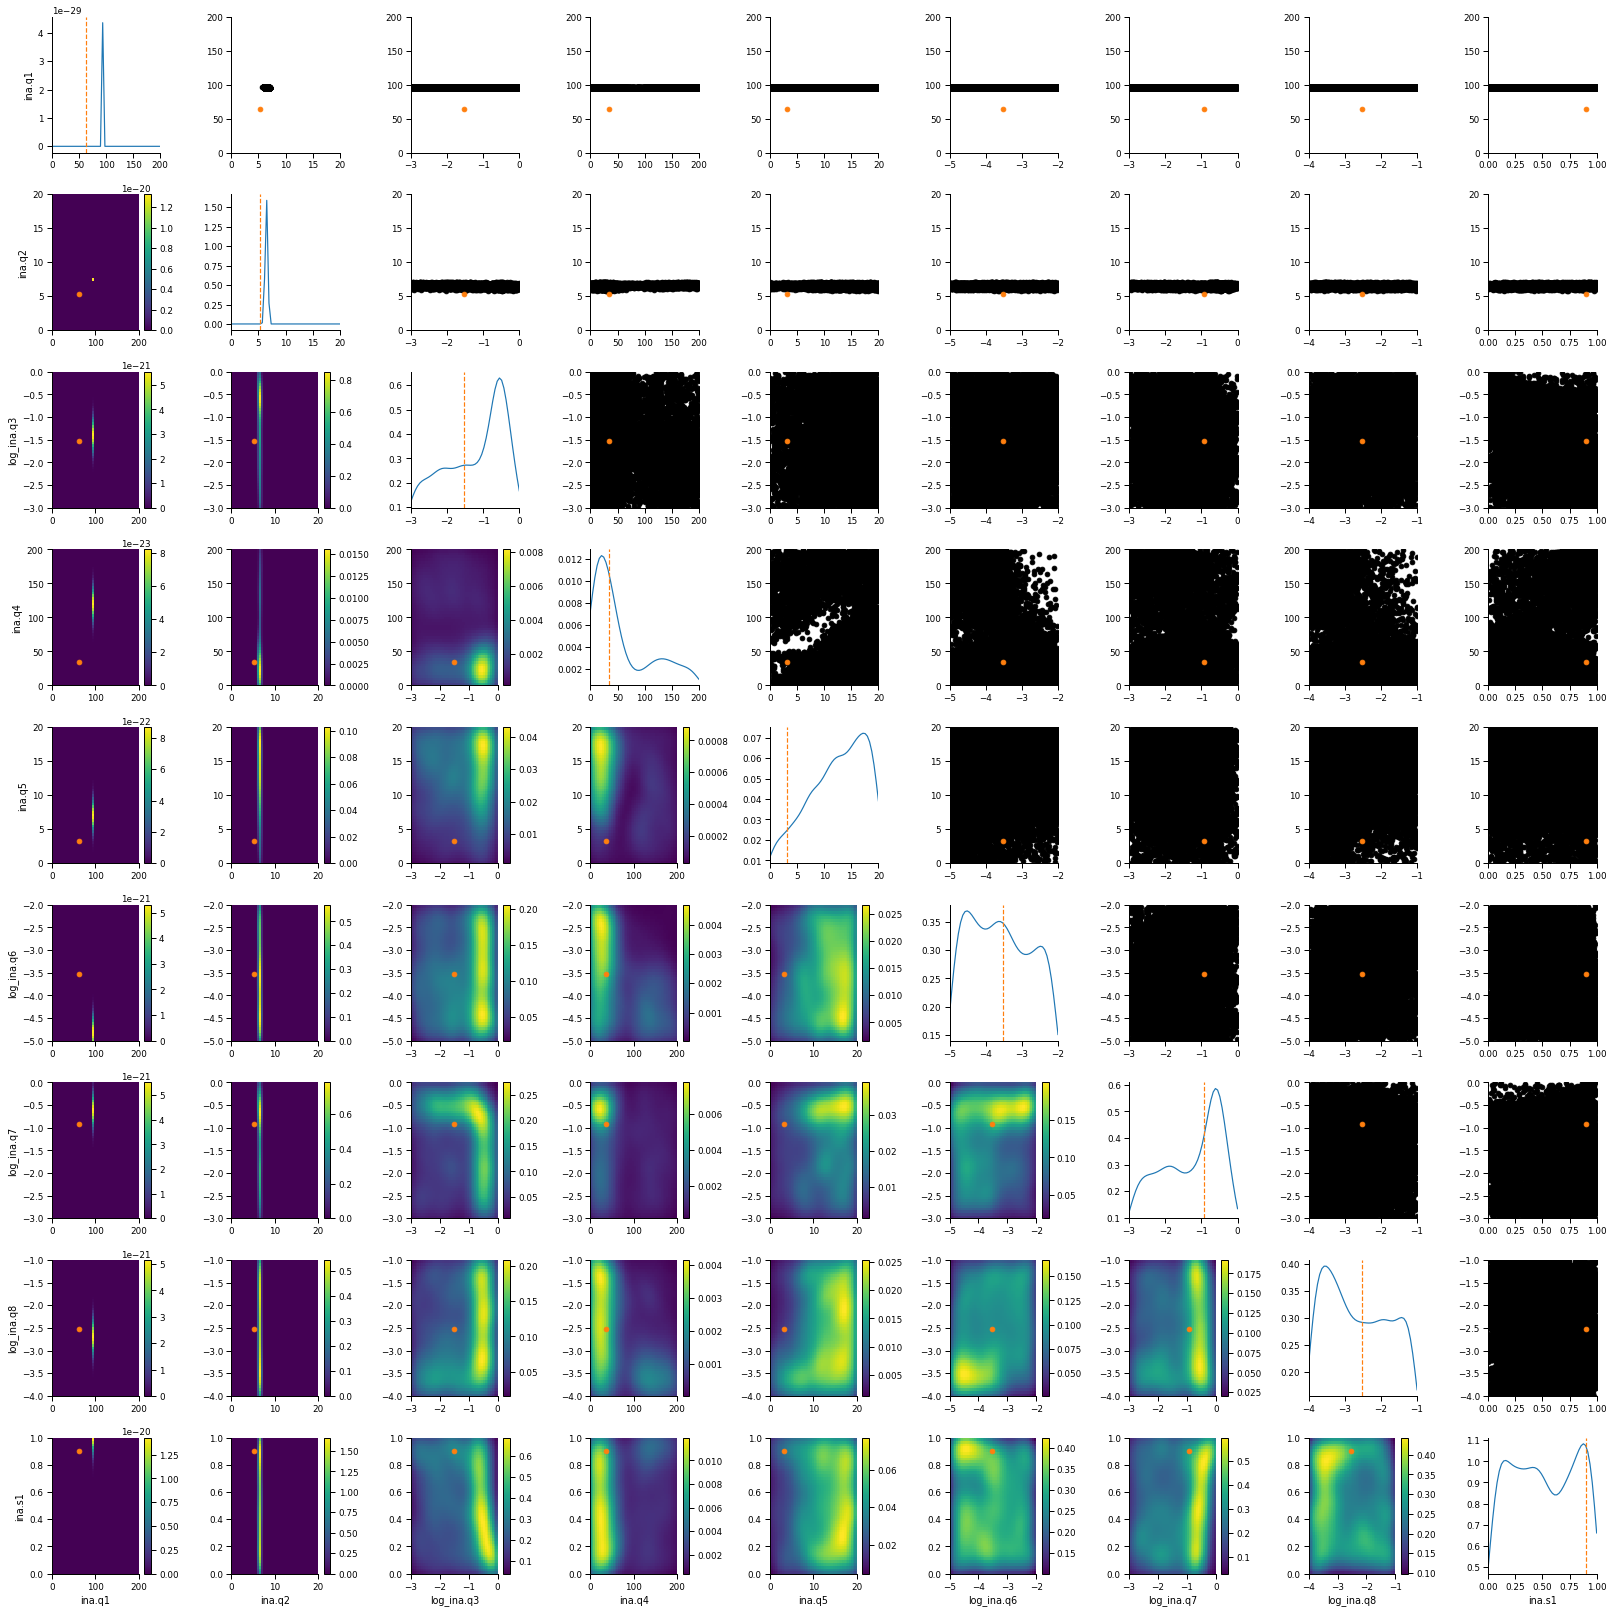

In [29]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df_inact, w, limits=limits_inact, refval=originals_inact)

### Plot traces

In [6]:
from ionchannelABC.visualization import plot_experiment_traces

In [7]:
h_nyg_orig = History("sqlite:///results/nygren/ina/original/nygren_ina_original.db")

In [8]:
df, w = h_nyg_orig.get_distribution(m=0)

In [9]:
modelfile = 'models/nygren_ina.mmt'

In [10]:
# Functions to extract a portion of the trace from experiments
def split_act(data):
    out = []
    for d in data.split_periodic(11000, adjust=True):
        d = d.trim(9950, 10200, adjust=False)
        out.append(d)
    return out
def split_inact(data):
    out = []
    for d in data.split_periodic(11030, adjust=True):
        d = d.trim(10950, 11030, adjust=False)
        out.append(d)
    return out

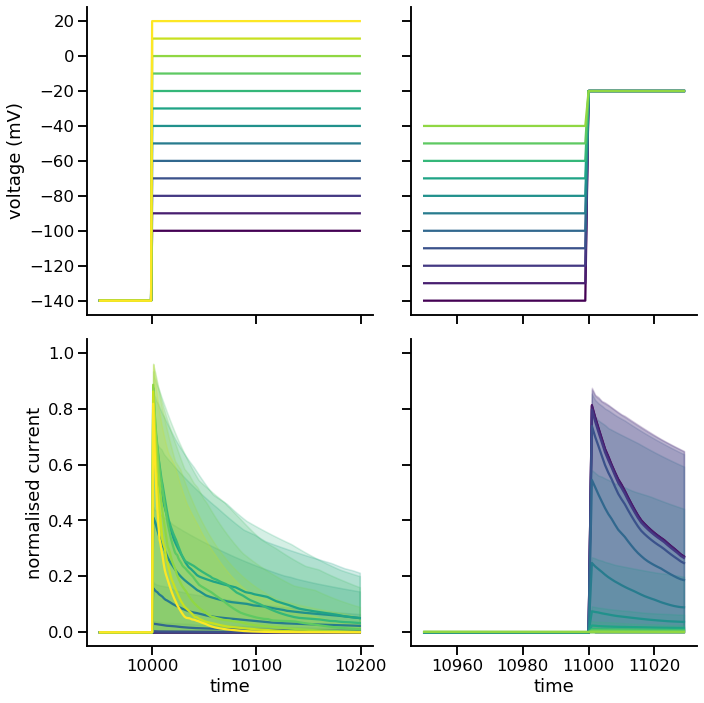

In [15]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_experiment_traces(modelfile, ['ina.g'], 
                           [split_act, split_inact],
                           sakakibara_act,
                           sakakibara_inact,
                           df=df, w=w, 
                           log_interval=1)

xlabel = "time (ms)"
ylabels = ["voltage (mV)", "normalised current"]
for ax in g.axes[0,:]:
    ax.set_xlabel(xlabel)
for ax, yl in zip(g.axes, ylabels):
    ax[0].set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title('')
for ax in g.axes[1,:]:
    ax.set_ylim([-0.05, 1.05])
    
plt.tight_layout()

In [17]:
#g.savefig('figures/ina/nyg_original_traces.pdf')

### Custom plotting

In [50]:
from pyabc.visualization import plot_kde_1d, plot_kde_2d
from pyabc.visualization.kde import kde_1d

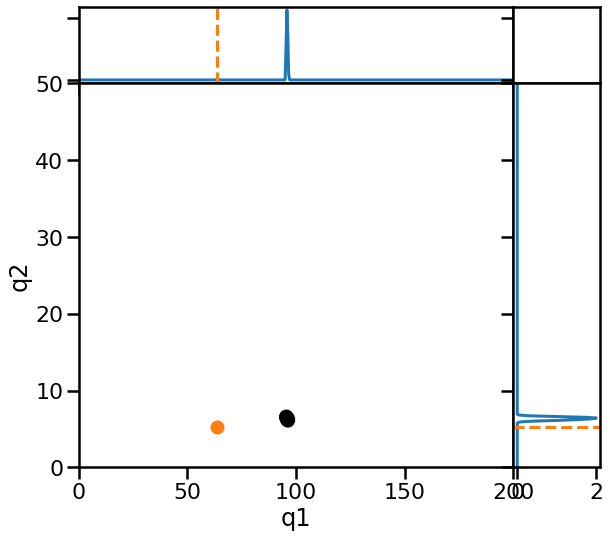

In [51]:
import seaborn as sns
sns.set_context('poster')

x = 'ina.q1'
y = 'ina.q2'

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,8),
                     sharex='col', sharey='row',
                     gridspec_kw={'width_ratios': [5, 1],
                                  'height_ratios': [1, 5],
                                  'hspace': 0,
                                  'wspace': 0})

plot_kde_1d(df, w, x, xmin=limits[x][0], xmax=limits[x][1], refval=originals_inact, ax=ax[0][0], numx=500)
x_vals, pdf = kde_1d(df, w, y, xmin=limits[y][0], xmax=limits[y][1], numx=500, kde=None)
ax[1][1].plot(pdf, x_vals)

ax[1][1].set_ylim(limits[y][0], limits[y][1])
ax[1][1].axhline(originals_inact[y], color='C1', linestyle='dashed')

alpha = w / w.max()
colors = np.zeros((alpha.size, 4))
colors[:, 3] = alpha

ax[1][0].scatter(df[x], df[y], color=colors)
ax[1][0].scatter([originals_inact[x]], [originals_inact[y]], color='C1')

# cleaning up
ax[0][0].set_xlabel('')
ax[0][0].set_ylabel('')
ax[1][0].set_ylabel(y[-2:])
ax[1][0].set_xlabel(x[-2:])
labels = [item.get_text() for item in ax[0][1].get_yticklabels()]
ax[0][1].set_yticklabels(['',]*len(labels))
ax[1][1].set_ylabel('')

plt.tight_layout()

In [52]:
#f.savefig('figures/ina/nygren_original_q1q2_scatter.pdf')